Importaciones y configuración inicial

In [10]:
import pandas as pd
import numpy as np
import json
from datetime import datetime

# Configuración general
SEED = 5200  # semilla 
N = 5200    # el último dígito de la cédula es 2
RAW_PATH = "../data/LifeStyleData.csv"
SUBSET_PATH = f"../data/subset/subset_lifestyledata_rows{N}_seed{SEED}.csv"
CLEAN_SUBSET_PATH = f"../data/subset/clean_subset_lifestyledata_rows{N}_seed{SEED}.csv"
META_PATH = "../data/subset/metadata.json"

pd.set_option('display.max_columns', None)

Cargar el dataset original y visualizarlo

In [11]:
df = pd.read_csv(RAW_PATH)
print("Shape original:", df.shape)
df.head()

Shape original: (20000, 54)


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Daily meals frequency,Physical exercise,Carbs,Proteins,Fats,Calories,meal_name,meal_type,diet_type,sugar_g,sodium_mg,cholesterol_mg,serving_size_g,cooking_method,prep_time_min,cook_time_min,rating,Name of Exercise,Sets,Reps,Benefit,Burns Calories (per 30 min),Target Muscle Group,Equipment Needed,Difficulty Level,Body Part,Type of Muscle,Workout,BMI_calc,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc,Burns_Calories_Bin
0,34.91,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,26.800377,1.50,3.99,2.01,24.87,2.99,0.01,267.68,106.05,71.63,1806.0,Other,Lunch,Vegan,31.77,1729.94,285.05,120.47,Grilled,16.24,110.79,1.31,Decline Push-ups,4.99,20.91,Improves shoulder health and posture,342.58,"Shoulders, Triceps",Cable Machine,Advanced,Legs,Lats,Dumbbell flyes,24.870447,2139.59,0.500432,1.624789,0.741237,0.835985,725.10,47.777394,685.1600,7.260425e+19,Medium
1,23.37,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,27.655021,1.90,4.00,2.01,23.48,3.01,0.97,214.32,85.41,56.97,1577.0,Other,Lunch,Vegetarian,12.34,693.08,300.61,109.15,Fried,16.47,12.01,1.92,Bear Crawls,4.01,16.15,Strengthens lower abs,357.16,"Back, Core, Shoulders",Step or Box,Intermediate,Chest,Lats,Lateral raises,23.479709,1711.65,0.500850,1.514093,0.551247,0.734270,-232.91,40.809803,978.6184,1.020506e+20,High
2,33.20,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,24.320821,1.88,2.99,1.02,21.15,1.99,-0.02,246.04,98.11,65.48,1608.0,Other,Breakfast,Paleo,42.81,2142.48,215.42,399.43,Boiled,54.35,6.09,4.70,Dips,5.00,21.90,Builds chest strength,359.63,"Quadriceps, Glutes",Step or Box,Intermediate,Arms,Grip Strength,Standing calf raises,21.148123,1965.92,0.500610,1.663445,0.574534,0.708124,805.74,44.635580,654.5266,1.079607e+20,High
3,38.69,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,32.813572,2.50,3.99,1.99,32.45,3.00,0.04,203.22,80.84,54.56,2657.0,Other,Lunch,Paleo,9.34,123.20,9.70,314.31,Fried,27.73,103.72,4.85,Mountain Climbers,4.01,16.92,Improves coordination and cardiovascular health,351.65,"Biceps, Forearms",Parallel Bars or Chair,Advanced,Shoulders,Upper,Incline dumbbell flyes,32.449827,1627.28,0.499533,0.862017,0.744155,0.811150,1206.21,63.007432,773.6300,8.987921e+19,High
4,45.09,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,17.307319,2.91,4.00,2.00,14.83,3.00,3.00,332.79,133.05,88.43,1470.0,Other,Breakfast,Vegan,23.78,1935.11,116.89,99.22,Baked,34.16,46.55,3.07,Bicep Curls,4.99,15.01,Targets obliques and improves core rotation,329.36,"Chest, Triceps",Wall,Advanced,Abs,Wrist Flexors,Military press,14.831372,2659.23,0.500581,2.538153,0.668405,0.789751,303.60,43.347504,711.4176,5.264685e+19,Low


Limpieza básica de la base de datos original

In [12]:
# limpiar valores nulos 
df = df.dropna()

# eliminar duplicados
df = df.drop_duplicates()

# tomar solo las columnas que vamos a estudiar
columns_to_use = ['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned', 'Workout_Type']
df = df[columns_to_use]

print("Shape después de limpiar columnas que no usaremos, nulos y duplicados:", df.shape)

Shape después de limpiar columnas que no usaremos, nulos y duplicados: (20000, 10)


Generación del subset reproducible

In [13]:
# Submuestreo reproducible
subset = df.sample(n=N, random_state=SEED).reset_index(drop=True)

# guardar a CSV
subset.to_csv(SUBSET_PATH, index=False, encoding='utf-8')

# guardar metadata
metadata = {
    "rows": N,
    "seed": SEED,
    "generated_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "source_file": RAW_PATH.split("/")[-1],
}
with open(META_PATH, "w") as f:
    json.dump(metadata, f, indent=4)

print("Subset guardado en:", SUBSET_PATH)
subset.head()

Subset guardado en: ../data/subset/subset_lifestyledata_rows5200_seed5200.csv


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type
0,21.14,Male,101.05,1.95,171.17,130.81,68.96,0.97,959.43,Strength
1,44.17,Male,41.63,1.78,167.33,158.46,63.95,1.48,1424.35,Cardio
2,20.07,Female,63.81,1.78,187.86,137.11,60.93,1.70,1766.64,Cardio
3,36.30,Female,59.77,1.78,183.83,120.32,60.01,0.85,1028.50,HIIT
4,51.99,Male,57.60,1.56,166.25,151.82,67.97,1.66,1295.80,Yoga


Limpieza en profundidad del subconjunto de datos

In [16]:
# convertir todas las columnas a tipo numérico, excepto Gender y Workout_Type
for col in subset.columns:
    if col not in ['Gender', 'Workout_Type']:
        subset[col] = pd.to_numeric(subset[col], errors='coerce')

# cambiar nombre weight (kg) a weight_kg, height (m) a height_m y session_duration (hours) a session_duration_hours
subset = subset.rename(columns={'Weight (kg)': 'Weight_kg', 'Height (m)': 'Height_m', 'Session_Duration (hours)': 'Session_Duration_hours'})

print("Columnas actuales del DataFrame:")
print(subset.columns.tolist())
subset.head()

Columnas actuales del DataFrame:
['Age', 'Gender', 'Weight_kg', 'Height_m', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration_hours', 'Calories_Burned', 'Workout_Type']


,Age,Gender,Weight_kg,Height_m,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration_hours,Calories_Burned,Workout_Type
0,21.14,Male,101.05,1.95,171.17,130.81,68.96,0.97,959.43,Strength
1,44.17,Male,41.63,1.78,167.33,158.46,63.95,1.48,1424.35,Cardio
2,20.07,Female,63.81,1.78,187.86,137.11,60.93,1.70,1766.64,Cardio
3,36.30,Female,59.77,1.78,183.83,120.32,60.01,0.85,1028.50,HIIT
4,51.99,Male,57.60,1.56,166.25,151.82,67.97,1.66,1295.80,Yoga


Guardado de subconjunto de datos completamente limpio y listo para usar

In [17]:
# guardar a CSV
subset.to_csv(CLEAN_SUBSET_PATH, index=False, encoding='utf-8')

print(subset.shape)
subset.head()

(5200, 10)


,Age,Gender,Weight_kg,Height_m,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration_hours,Calories_Burned,Workout_Type
0,21.14,Male,101.05,1.95,171.17,130.81,68.96,0.97,959.43,Strength
1,44.17,Male,41.63,1.78,167.33,158.46,63.95,1.48,1424.35,Cardio
2,20.07,Female,63.81,1.78,187.86,137.11,60.93,1.70,1766.64,Cardio
3,36.30,Female,59.77,1.78,183.83,120.32,60.01,0.85,1028.50,HIIT
4,51.99,Male,57.60,1.56,166.25,151.82,67.97,1.66,1295.80,Yoga


Información general del dataset

In [18]:
# Información general del dataset
subset.info()

# Resumen estadístico solo de las columnas numéricas
print("\n--- Estadísticas descriptivas (numéricas) ---")
print(subset.describe())

# Revisión rápida de valores nulos por columna
print("\n--- Valores nulos por columna ---")
print(subset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     5200 non-null   float64
 1   Gender                  5200 non-null   object 
 2   Weight_kg               5200 non-null   float64
 3   Height_m                5200 non-null   float64
 4   Max_BPM                 5200 non-null   float64
 5   Avg_BPM                 5200 non-null   float64
 6   Resting_BPM             5200 non-null   float64
 7   Session_Duration_hours  5200 non-null   float64
 8   Calories_Burned         5200 non-null   float64
 9   Workout_Type            5200 non-null   object 
dtypes: float64(8), object(2)
memory usage: 406.4+ KB

--- Estadísticas descriptivas (numéricas) ---
               Age    Weight_kg     Height_m      Max_BPM      Avg_BPM  \
count  5200.000000  5200.000000  5200.000000  5200.000000  5200.000000   
mean    

Distribución de variables numéricas


Columnas numéricas: ['Age', 'Weight_kg', 'Height_m', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration_hours', 'Calories_Burned']

Age: rango = 18.0 → 59.67


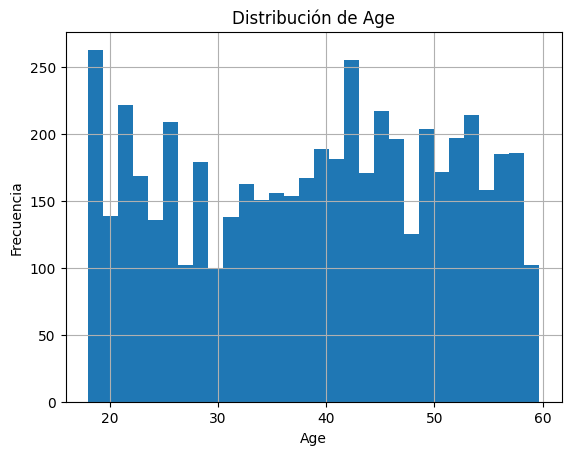


Weight_kg: rango = 39.28 → 130.55


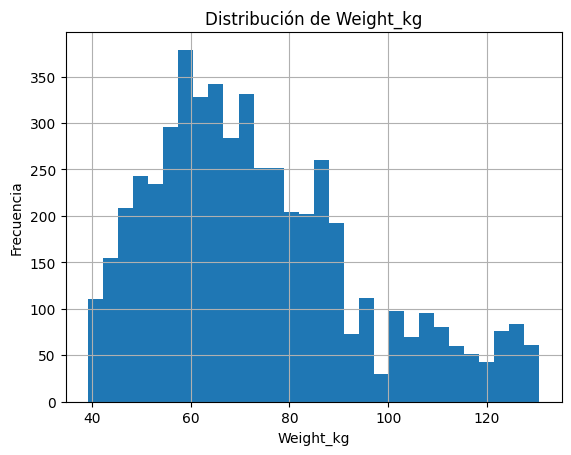


Height_m: rango = 1.49 → 2.01


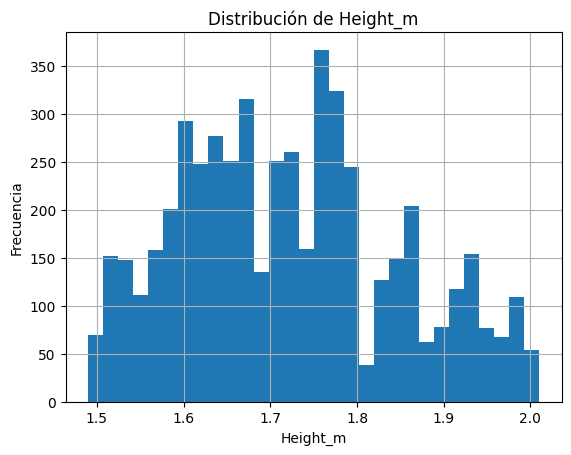


Max_BPM: rango = 159.37 → 199.53


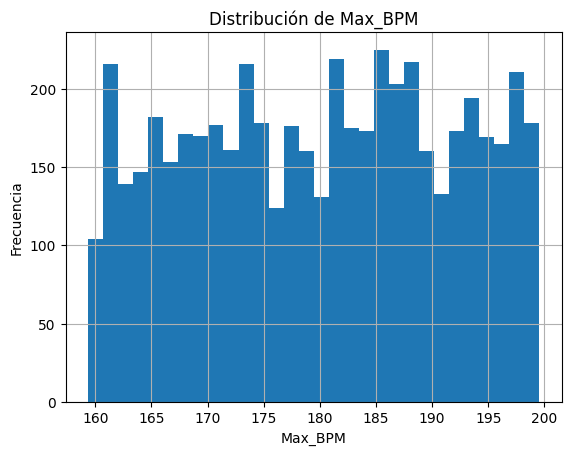


Avg_BPM: rango = 119.29 → 169.84


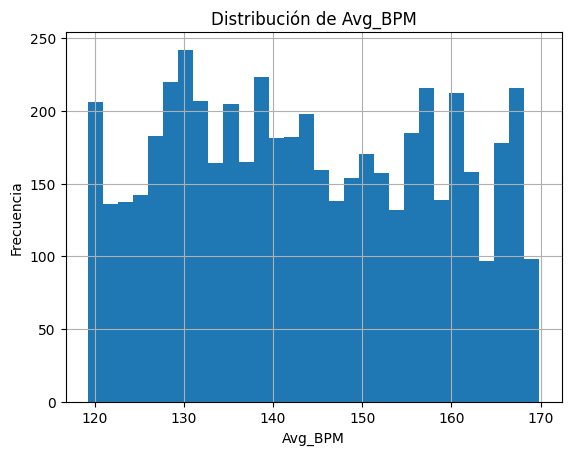


Resting_BPM: rango = 49.66 → 74.41


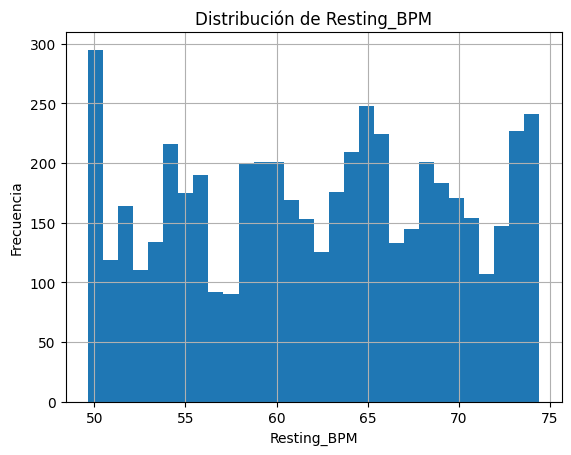


Session_Duration_hours: rango = 0.49 → 2.01


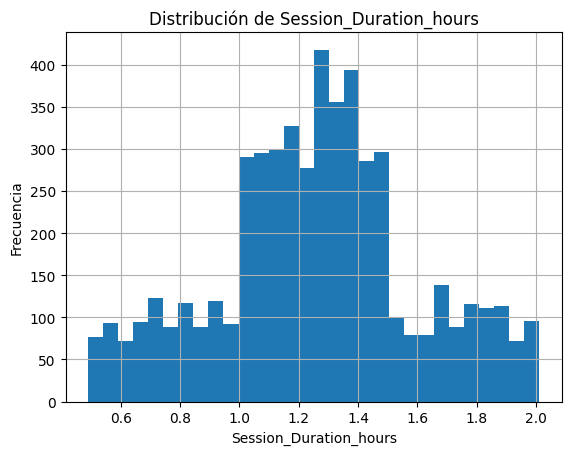


Calories_Burned: rango = 330.3 → 2862.2


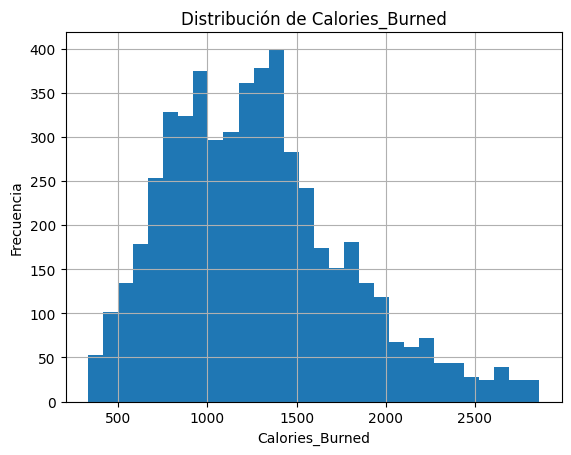

In [19]:
import matplotlib.pyplot as plt

numeric_cols = subset.select_dtypes(include='number').columns.tolist()
print("\nColumnas numéricas:", numeric_cols)

# Verifica si hay valores no numéricos o atípicos
for col in numeric_cols:
    print(f"\n{col}: rango = {subset[col].min()} → {subset[col].max()}")
    subset[col].hist(bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()
